<a href="https://colab.research.google.com/github/AzureAmber/STAT-390-Covid-Project/blob/ericazhang/Models/erica/6_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# These two lines avoid dead kernel after importing keras
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'

import keras

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from keras.layers import LSTM, Dense, Input
from keras.models import Sequential
from keras import Model
from keras.optimizers import Adam
from pandas.plotting import autocorrelation_plot
import time as time
warnings.filterwarnings("ignore")

In [7]:
train = pd.read_csv('train_nn.csv', parse_dates = ['date'])
train = train.drop(['continent', 'G20', 'G24'], axis = 1)
test = pd.read_csv('test_nn.csv', parse_dates = ['date'])
test = test.drop(['continent', 'G20', 'G24'], axis = 1)

print(train.shape)
print(test.shape)

(24771, 34)
(5900, 34)


In [8]:
# encode non-numeric features

days = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
train['day_of_week'] = train['day_of_week'].map(days)
test['day_of_week'] = test['day_of_week'].map(days)

indicator_columns = ['total_tests_b', 'new_tests_b', 'positive_rate_b', 'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']

# Convert indicator variables to numeric: True to 1 and False to 0
for col in indicator_columns:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

train.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,...,life_expectancy,population,month,day_of_week,total_tests_b,new_tests_b,positive_rate_b,total_vaccinations_b,extreme_poverty_b,stringency_index_b
0,Argentina,2020-01-20,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,1,1,1,1,0,1,1
1,Argentina,2020-01-21,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,2,1,1,1,0,1,1
2,Argentina,2020-01-22,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,3,1,1,1,0,1,1
3,Argentina,2020-01-23,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,4,1,1,1,0,1,1
4,Argentina,2020-01-24,5349898.0,0,127500.0,0,80946.854,0.0,1785.094,0.0,...,76.67,45510324,1,5,0,0,0,0,1,1


In [9]:
# add one-wk lag for new_cases

def add_lagged_features(df, target, lag_periods):
    lagged_df = df[[target]].shift(lag_periods)
    lagged_df.columns = [f'lag{lag_periods}_' + target]
    existing_lagged_col = f'lag{lag_periods}_' + target
    if existing_lagged_col in df.columns:
        df = df.drop(columns=[existing_lagged_col])
    df_with_lags = df.join(lagged_df)
    return df_with_lags.fillna(0)

train_with_lags = add_lagged_features(train, 'new_cases', 7)
test_with_lags = add_lagged_features(test, 'new_cases', 7)

In [10]:
# normalize on country-level

def normalize(df, group_col, target, indicators, non_numeric):

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cols_to_normalize = numeric_cols.difference(indicators + [target] + non_numeric)

    df_normalized = df.copy()
    for col in cols_to_normalize:
        # Apply normalization within each region for the column
        df_normalized[col] = df.groupby(group_col)[col].transform(lambda x: (x - x.mean()) / x.std())

    df_normalized = df_normalized.fillna(0)
    return df_normalized

# List of indicator columns and non-numeric columns
indicators = ['total_tests_b', 'new_tests_b', 'positive_rate_b',
              'total_vaccinations_b', 'extreme_poverty_b', 'stringency_index_b']
non_numeric = ['date', 'location', 'day_of_week']

# Apply the normalize function to your train and test sets
train_normalized = normalize(train_with_lags, 'location', 'new_cases', indicators, non_numeric)
test_normalized = normalize(test_with_lags, 'location', 'new_cases', indicators, non_numeric)


#train_encoded = pd.get_dummies(train_normalized, columns=['location'])
#test_encoded = pd.get_dummies(test_normalized, columns=['location'])

In [17]:
data=pd.concat([train_normalized, test_normalized])

data.set_index('date', inplace = True)

# select out region of interest
US_data = data.loc[data.location == 'United States'].drop(columns = ['location']).astype(float)

US_data.head(10)

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,reproduction_rate,total_tests,...,population,month,day_of_week,total_tests_b,new_tests_b,positive_rate_b,total_vaccinations_b,extreme_poverty_b,stringency_index_b,lag7_new_cases
date,,,,,,,,,,,,,,,,,,,,,
2020-01-20,-1.249983,1.0,-1.310589,-1.087541,-1.249983,-0.719431,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.694349
2020-01-21,-1.249983,0.0,-1.310589,-1.087541,-1.249983,-0.719439,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,2.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.707296
2020-01-22,-1.249983,0.0,-1.310589,-1.087541,-1.249983,-0.719439,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.710821
2020-01-23,-1.249983,0.0,-1.310589,-1.087541,-1.249983,-0.719439,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,4.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.700714
2020-01-24,-1.249983,0.0,-1.310589,-1.087541,-1.249983,-0.719439,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,5.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.687397
2020-01-25,-1.249983,5.0,-1.310589,-1.087541,-1.249983,-0.719400,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,6.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.672800
2020-01-26,-1.249983,1.0,-1.310589,-1.087541,-1.249983,-0.719431,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,7.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.678441
2020-01-27,-1.249983,0.0,-1.310589,-1.087541,-1.249983,-0.719439,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.740538
2020-01-28,-1.249983,1.0,-1.310589,-1.087541,-1.249983,-0.719431,-0.02624,-1.087917,-0.127993,-0.91304,...,0.0,-1.652118,2.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.740546


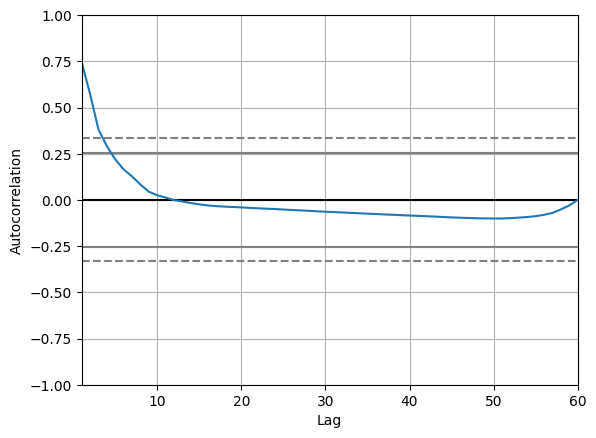

In [18]:
# Plot autocorrelation for a more reasonable number of lags
autocorrelation_plot(US_data['new_cases'].iloc[:60])
plt.show()

# 14 looks like a reasonable lag to capture bi-weekly seasonality

In [34]:
def make_series(data):
    series=[]
    for i in range(14, len(data)+1):
        subdf=data[(i-14):i]
        series.append((data.index[i-1], data['new_cases'].values[i-1], subdf.drop(['new_cases'], axis=1).values))
    return series

series=make_series(US_data)
print(series[0][0], series[0][1].shape, series[0][2].shape)
US_train = series[:(US_data.loc[US_data.index < '2023-01-01'].shape[0]-13)]
US_test = series[(US_data.loc[US_data.index < '2023-01-01'].shape[0]-13):]

2020-02-02 00:00:00 () (14, 32)


# Training

In [35]:
learning_rate = 0.02
batch_size = 32
epochs = 200
sequence_length = 14

In [36]:
inputs = Input(shape=(14,32))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 14, 32)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8353 (32.63 KB)
Trainable params: 8353 (32.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [37]:
x=np.array([x[2].reshape(14,32)for x in US_train])
y=np.array([x[1] for x in US_train])

print(x.shape)
print(y.shape)

history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(1064, 14, 32)
(1064,)
Epoch 1/200
34/34 [==============================] - 2s 4ms/step - loss: 24210419712.0000
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 24206065664.0000
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 24201916416.0000
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 24197892096.0000
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 24193767424.0000
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 24189718528.0000
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 24185573376.0000
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 24181395456.0000
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 24177385472.0000
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 24173369344.0000
Epoch 11/200
34/34 [==============================] - 0s 4ms/step - loss: 24

In [38]:
US_train_pred = pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
US_test_pred = pd.DataFrame(model.predict(np.array([x[2].reshape(14,32) for x in US_test])), columns=['yhat'], index=[x[0] for x in US_test])
US_test_pred

8/8 [==============================] - 0s 2ms/step


,yhat
2023-01-01,4207.057617
2023-01-02,4207.041504
2023-01-03,4222.776367
2023-01-04,4226.411621
2023-01-05,4230.048828
...,...
2023-09-09,4338.442383
2023-09-10,4338.442383
2023-09-11,4338.440430
2023-09-12,4338.440918


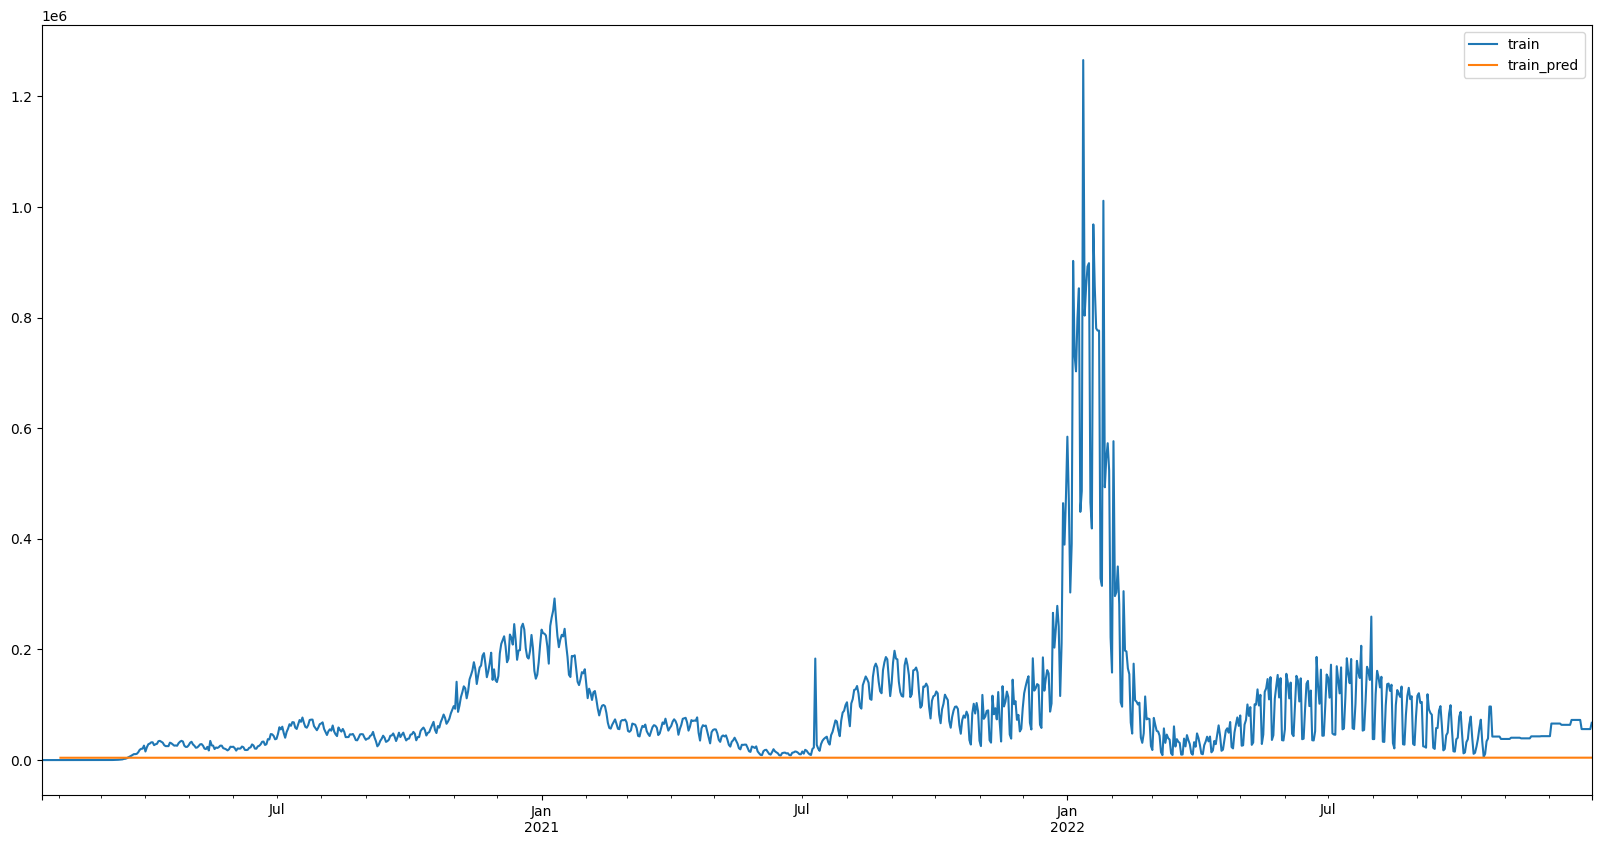

In [41]:
# plotting the training data
y_train_actual = train_normalized.loc[train_normalized.location == 'United States', 'new_cases']
y_train_actual.index = train_normalized.loc[train_normalized.location == 'United States', 'date']
pd.concat([y_train_actual, US_train_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])

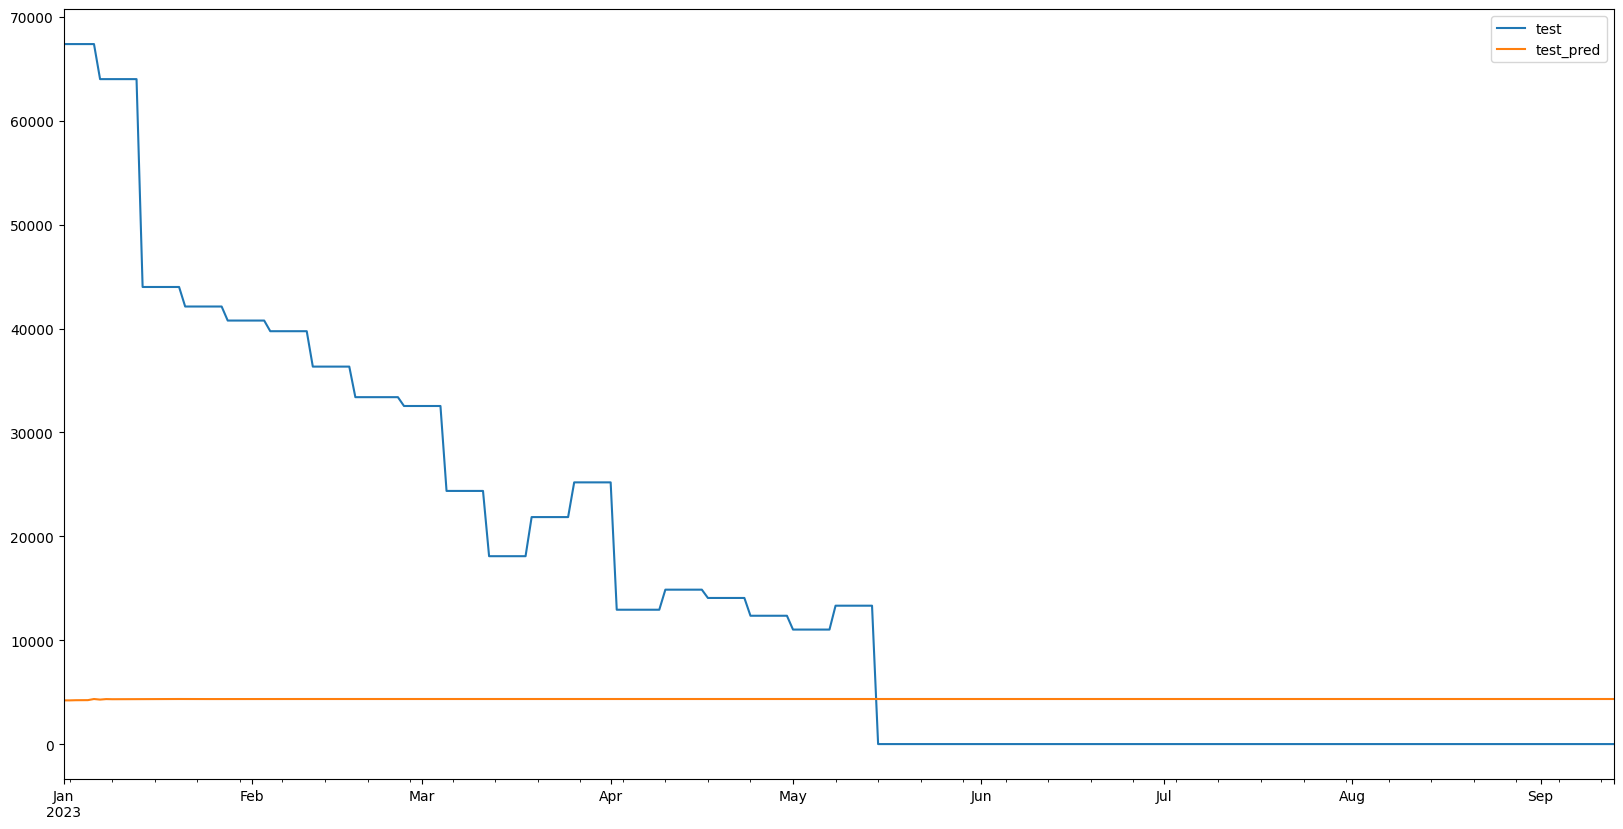

In [40]:
# plottting the testing data
y_test_actual = test_normalized.loc[test_normalized.location == 'United States', 'new_cases']
y_test_actual.index = test_normalized.loc[test_normalized.location == 'United States', 'date']
pd.concat([y_test_actual, US_test_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])

In [44]:
print("The rmse on the US training data is", mean_squared_error(y_train_actual[13:], US_train_pred['yhat'], squared = False))
print("The rmse on the US testing data is", mean_squared_error(y_test_actual, US_test_pred['yhat'], squared = False))

The rmse on the US training data is 153037.52564955386
The rmse on the US testing data is 21867.584681742945


No trend is capturing at all - we need to tune the hyperparameter


In [45]:
import itertools

# initialize combinations to test
learning_rate = [0.01, 0.02, 0.05]
epochs = [100, 200, 300]
batch_size =[16, 32, 64]
combination = list(itertools.product(learning_rate, epochs, batch_size))
combination

[(0.01, 100, 16),
 (0.01, 100, 32),
 (0.01, 100, 64),
 (0.01, 200, 16),
 (0.01, 200, 32),
 (0.01, 200, 64),
 (0.01, 300, 16),
 (0.01, 300, 32),
 (0.01, 300, 64),
 (0.02, 100, 16),
 (0.02, 100, 32),
 (0.02, 100, 64),
 (0.02, 200, 16),
 (0.02, 200, 32),
 (0.02, 200, 64),
 (0.02, 300, 16),
 (0.02, 300, 32),
 (0.02, 300, 64),
 (0.05, 100, 16),
 (0.05, 100, 32),
 (0.05, 100, 64),
 (0.05, 200, 16),
 (0.05, 200, 32),
 (0.05, 200, 64),
 (0.05, 300, 16),
 (0.05, 300, 32),
 (0.05, 300, 64)]

In [48]:
rmse_list = []
combination_list = []
x=np.array([x[2].reshape(14,32) for x in US_train])
y=np.array([x[1] for x in US_train])
for comb in combination:
    learning_rate = comb[0]
    epochs = comb[1]
    batch_size = comb[2]
    # initialize model
    inputs = Input(shape=(14,32))
    lstm_out = LSTM(32)(inputs)
    outputs = Dense(1)(lstm_out)
    model_tuned = Model(inputs=inputs, outputs=outputs)
    model_tuned.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    history = model_tuned.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)
    US_train_pred_tuned=pd.DataFrame(model_tuned.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
    rmse = mean_squared_error(y_train_actual[13:], US_train_pred_tuned['yhat'], squared = False)
    rmse_list.append(rmse)
    combination_list.append(comb)

Streaming output truncated to the last 5000 lines.
67/67 [==============================] - 0s 4ms/step - loss: 22677524480.0000
Epoch 208/300
67/67 [==============================] - 0s 4ms/step - loss: 22670544896.0000
Epoch 209/300
67/67 [==============================] - 0s 4ms/step - loss: 22663522304.0000
Epoch 210/300
67/67 [==============================] - 0s 4ms/step - loss: 22656522240.0000
Epoch 211/300
67/67 [==============================] - 0s 4ms/step - loss: 22649477120.0000
Epoch 212/300
67/67 [==============================] - 0s 4ms/step - loss: 22642452480.0000
Epoch 213/300
67/67 [==============================] - 0s 4ms/step - loss: 22635472896.0000
Epoch 214/300
67/67 [==============================] - 0s 4ms/step - loss: 22628442112.0000
Epoch 215/300
67/67 [==============================] - 0s 4ms/step - loss: 22621460480.0000
Epoch 216/300
67/67 [==============================] - 0s 4ms/step - loss: 22614482944.0000
Epoch 217/300
67/67 [======================

In [49]:
results = pd.DataFrame(index = combination_list, data = rmse_list, columns = ['rmse'])
results.reset_index(inplace = True)
results.sort_values(by = 'rmse', ascending = True).iloc[0,0]

(0.05, 300, 16)

In [51]:
# tuned model
learning_rate = 0.05
batch_size = 16
epochs = 300
sequence_length =14
inputs = Input(shape=(14,32))
lstm_out = LSTM(32)(inputs)
outputs = Dense(1)(lstm_out)
model_best = Model(inputs=inputs, outputs=outputs)
model_best.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
x=np.array([x[2].reshape(14,32) for x in US_train])
y=np.array([x[1] for x in US_train])
print(x.shape)
print(y.shape)
history_best = model_best.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)


(1064, 14, 32)
(1064,)
Epoch 1/300
67/67 [==============================] - 2s 4ms/step - loss: 24203452416.0000
Epoch 2/300
67/67 [==============================] - 0s 4ms/step - loss: 24184363008.0000
Epoch 3/300
67/67 [==============================] - 0s 4ms/step - loss: 24165406720.0000
Epoch 4/300
67/67 [==============================] - 0s 4ms/step - loss: 24146571264.0000
Epoch 5/300
67/67 [==============================] - 0s 4ms/step - loss: 24127580160.0000
Epoch 6/300
67/67 [==============================] - 0s 4ms/step - loss: 24108679168.0000
Epoch 7/300
67/67 [==============================] - 0s 4ms/step - loss: 24089681920.0000
Epoch 8/300
67/67 [==============================] - 0s 4ms/step - loss: 24070918144.0000
Epoch 9/300
67/67 [==============================] - 0s 4ms/step - loss: 24051976192.0000
Epoch 10/300
67/67 [==============================] - 0s 4ms/step - loss: 24033280000.0000
Epoch 11/300
67/67 [==============================] - 0s 4ms/step - loss: 24

In [53]:
US_train_best_pred = pd.DataFrame(model_best.predict(x), columns=['yhat'], index=[x[0] for x in US_train])
US_test_best_pred = pd.DataFrame(model_best.predict(np.array([x[2].reshape(14,32) for x in US_test])), columns=['yhat'], index=[x[0] for x in US_test ])

US_test_best_pred

8/8 [==============================] - 0s 2ms/step


,yhat
2023-01-01,28471.865234
2023-01-02,28471.865234
2023-01-03,28471.865234
2023-01-04,28471.865234
2023-01-05,28471.865234
...,...
2023-09-09,29392.724609
2023-09-10,29392.724609
2023-09-11,29392.724609
2023-09-12,29392.724609


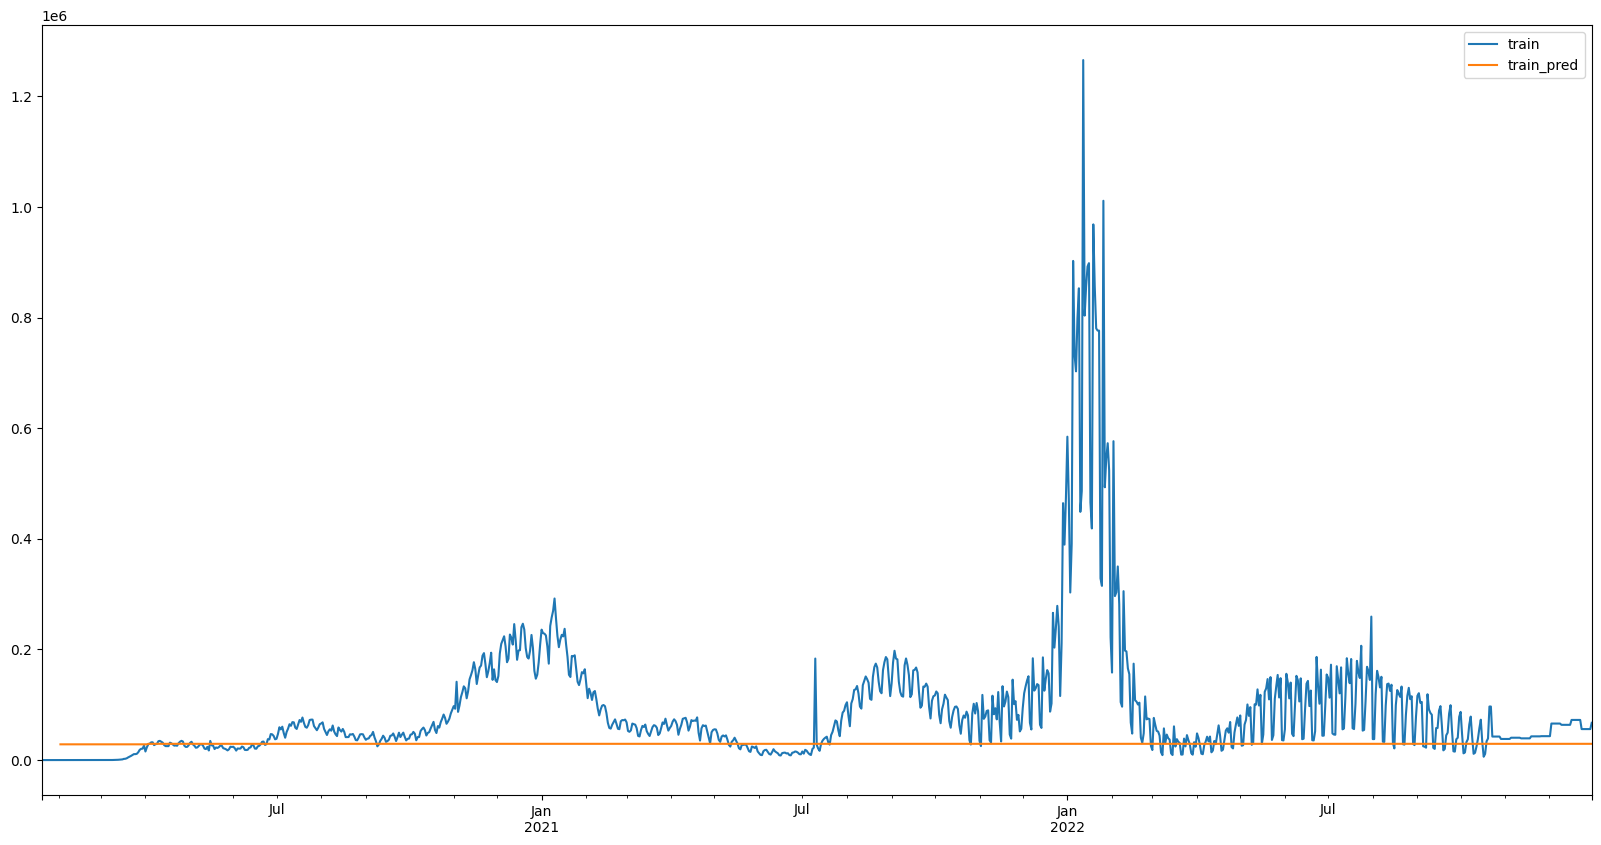

In [54]:
# plotting the training data

y_train_actual_best = train_normalized.loc[train_normalized.location == 'United States', 'new_cases']
y_train_actual_best.index = train_normalized.loc[train_normalized.location == 'United States', 'date']
pd.concat([y_train_actual_best, US_train_best_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['train', 'train_pred'])

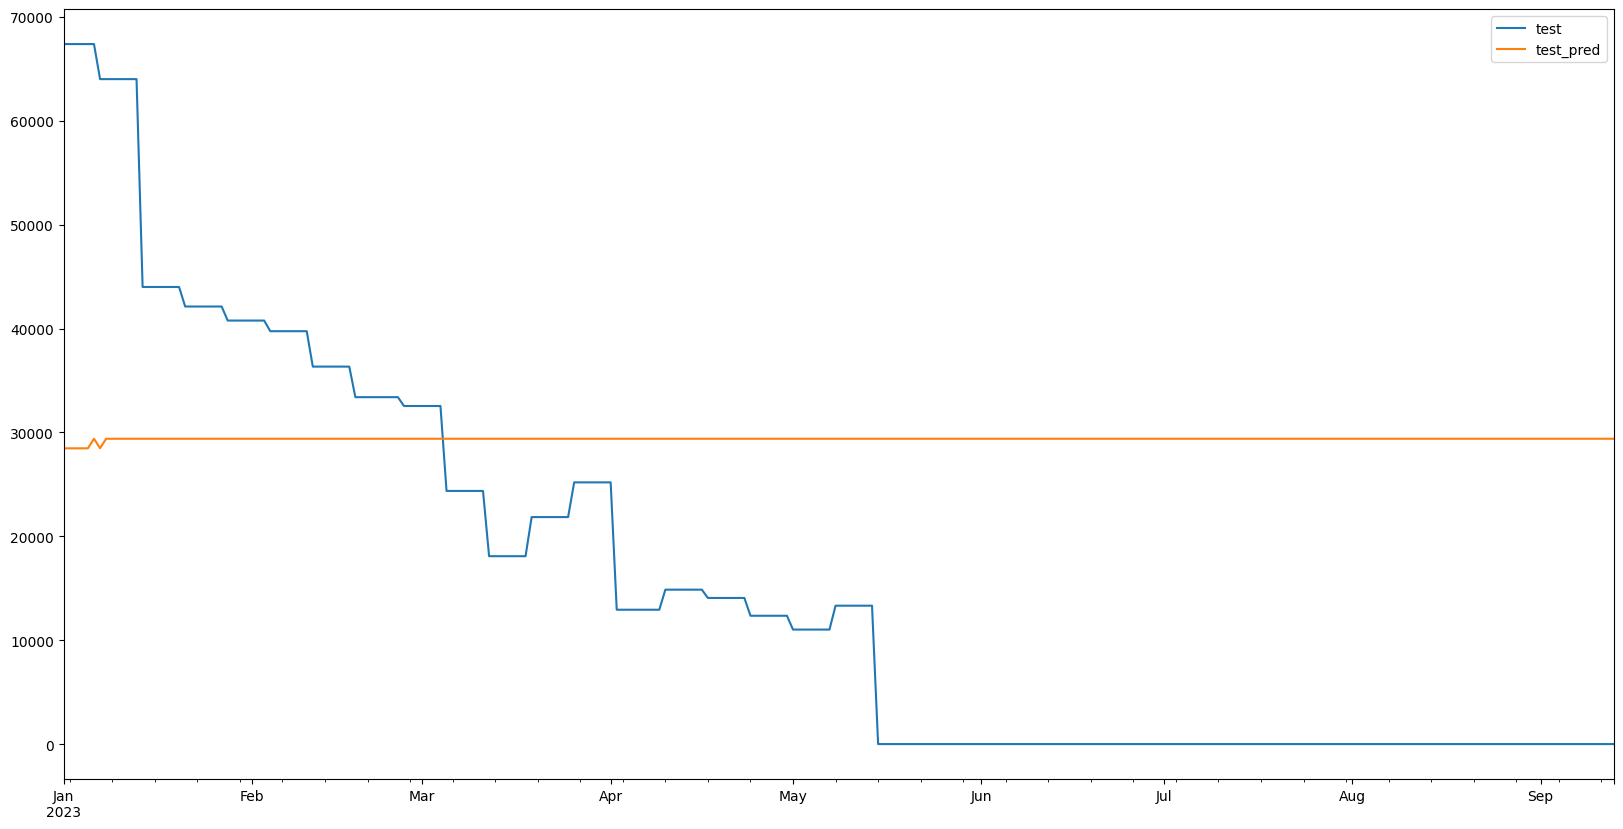

In [55]:
# plottting the testing data
y_test_actual_best = test_normalized.loc[test_normalized.location == 'United States', 'new_cases']
y_test_actual_best.index = test_normalized.loc[test_normalized.location == 'United States', 'date']
pd.concat([y_test_actual_best, US_test_best_pred['yhat']], axis=1).plot(figsize=(20,10))
plt.legend(['test', 'test_pred'])

In [56]:
print("The rmse on the US training data is", mean_squared_error(y_train_actual_best[13:], US_train_best_pred['yhat'], squared = False))
print("The rmse on the US testing data is", mean_squared_error(y_test_actual_best, US_test_best_pred['yhat'], squared = False))

The rmse on the US training data is 139921.53175604163
The rmse on the US testing data is 23449.88448509526
